# Deep Learning Assignment 3 - Part 2
### Latent Space Visualization

Student 1: Raneem Ibraheem + 212920896

Student 2: Aseel Nahhas + 212245096

# Imports

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# Preprocessing

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



9913344it [02:07, 77766.30it/s]                              


Extracting C:\Users\Alpha/datasets\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Alpha/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



29696it [00:00, 207598.39it/s]                           


Extracting C:\Users\Alpha/datasets\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Alpha/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



1649664it [00:13, 120439.88it/s]                             


Extracting C:\Users\Alpha/datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Alpha/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



5120it [00:00, 2509328.87it/s]          

Extracting C:\Users\Alpha/datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Alpha/datasets\MNIST\raw



# Encoder Class

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mean = self.fc_mean(h)
        log_var = self.fc_log_var(h)
        return mean, log_var

# Decoder Class

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

# Variational Auto Encoder Class

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2, device=device):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
        
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [8]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)

# Loss Function Class


In [9]:
def loss_function(x, x_hat, mean, log_var):
    eps = 1e-8
    BCE = - torch.sum(x * torch.log(x_hat + eps) + (1 - x) * torch.log(1 - x_hat + eps))
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - torch.exp(log_var))
    return BCE + KLD

# Training Loop

In [10]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), x_dim).to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/((batch_idx+1)*x.size(0)))
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                z = torch.zeros(2).to(device)
                sample = model.decoder(z).cpu().view(28,28)
            plt.imshow(sample, cmap='gray')
            plt.title(f"Sample reconstruction at epoch {epoch+1}")
            plt.axis('off')
            plt.show()
            model.train()
            
    return overall_loss

	Epoch 1 	Average Loss:  186.87213274739582
	Epoch 2 	Average Loss:  167.85075428059895
	Epoch 3 	Average Loss:  163.76542752278647
	Epoch 4 	Average Loss:  161.5311160970052
	Epoch 5 	Average Loss:  160.01145001627603
	Epoch 6 	Average Loss:  158.80165110677083
	Epoch 7 	Average Loss:  157.75338111979167
	Epoch 8 	Average Loss:  156.76464819335936
	Epoch 9 	Average Loss:  155.9061931640625
	Epoch 10 	Average Loss:  155.19695498046875


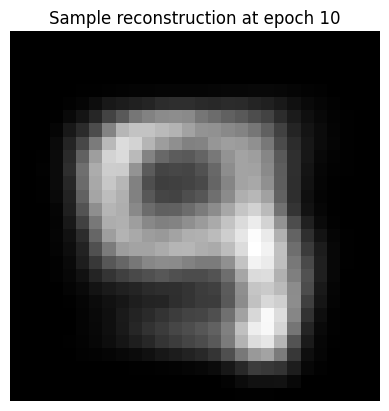

	Epoch 11 	Average Loss:  154.56659239908853
	Epoch 12 	Average Loss:  153.95710743815104
	Epoch 13 	Average Loss:  153.41690940755208
	Epoch 14 	Average Loss:  152.9015845377604
	Epoch 15 	Average Loss:  152.46318522135417
	Epoch 16 	Average Loss:  152.02315983072916
	Epoch 17 	Average Loss:  151.65369555664063
	Epoch 18 	Average Loss:  151.24268919270833
	Epoch 19 	Average Loss:  150.9279337890625
	Epoch 20 	Average Loss:  150.61141110026043


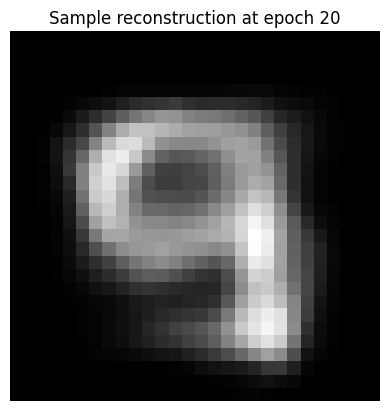

	Epoch 21 	Average Loss:  150.3514620768229
	Epoch 22 	Average Loss:  150.05220724283853
	Epoch 23 	Average Loss:  149.77968113606772
	Epoch 24 	Average Loss:  149.50595849609374
	Epoch 25 	Average Loss:  149.28315045572916
	Epoch 26 	Average Loss:  149.07881427408853
	Epoch 27 	Average Loss:  148.83588494466144
	Epoch 28 	Average Loss:  148.6647246907552
	Epoch 29 	Average Loss:  148.4535997558594
	Epoch 30 	Average Loss:  148.2983779296875


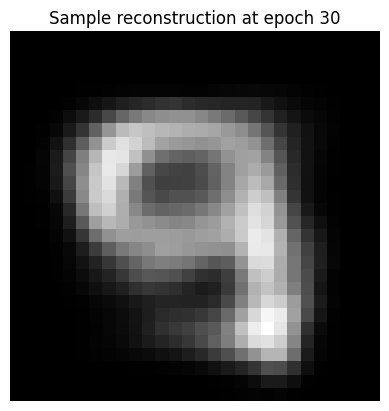

	Epoch 31 	Average Loss:  148.1658870768229
	Epoch 32 	Average Loss:  147.9055993001302
	Epoch 33 	Average Loss:  147.7731025065104
	Epoch 34 	Average Loss:  147.73614420572918
	Epoch 35 	Average Loss:  147.49121599934895
	Epoch 36 	Average Loss:  147.34576546223957
	Epoch 37 	Average Loss:  147.24918728841146
	Epoch 38 	Average Loss:  147.06270052083335
	Epoch 39 	Average Loss:  146.95755532226562
	Epoch 40 	Average Loss:  146.88640877278647


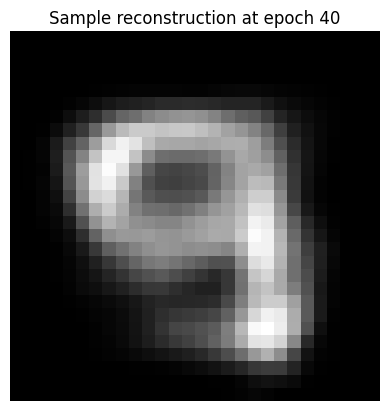

	Epoch 41 	Average Loss:  146.68636097005208
	Epoch 42 	Average Loss:  146.60495167643228
	Epoch 43 	Average Loss:  146.50202036132814
	Epoch 44 	Average Loss:  146.35178566080728
	Epoch 45 	Average Loss:  146.26623583984374
	Epoch 46 	Average Loss:  146.12970190429687
	Epoch 47 	Average Loss:  146.04915419921875
	Epoch 48 	Average Loss:  145.97232830403647
	Epoch 49 	Average Loss:  145.77099360351562
	Epoch 50 	Average Loss:  145.71901617838543


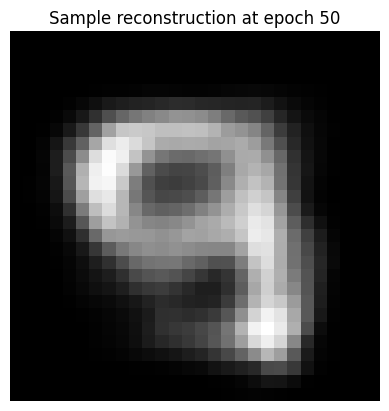

8743140.970703125

In [11]:
train(model, optimizer, epochs=50, device=device)

# Generate and plot digit

In [12]:
def generate_digit(mean, var):
    latent = torch.tensor([mean, var]).to(device)
    with torch.no_grad():
        model.eval()
        digit = model.decoder(latent).cpu().view(28, 28)
    def plot_digit():
        plt.imshow(digit, cmap="gray")
        plt.title(f"Generated digit with latent vector: [{mean}, {var}]")
        plt.axis('off')
        plt.show()
    return plot_digit

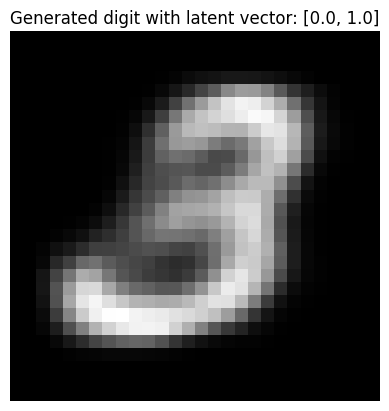

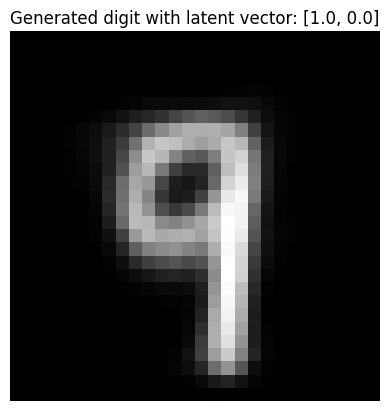

In [14]:
gen1 = generate_digit(0.0, 1.0)
gen2 = generate_digit(1.0, 0.0)
gen1()
gen2()

In [15]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

(<function __main__.generate_digit.<locals>.plot_digit()>,
 <function __main__.generate_digit.<locals>.plot_digit()>)

# Latent Space Grid Visualization

In [18]:
def plot_latent_space(model, scale, digit_size=28, figsize=15, grid_size=20):
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size))
    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)[::-1]
    
    with torch.no_grad():
        model.eval()
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.tensor([xi, yi], dtype=torch.float32).to(device)
                x_hat = model.decoder(z).cpu().numpy()
                digit = x_hat.reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = grid_size * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.title("Latent Space Visualization")
    plt.show()

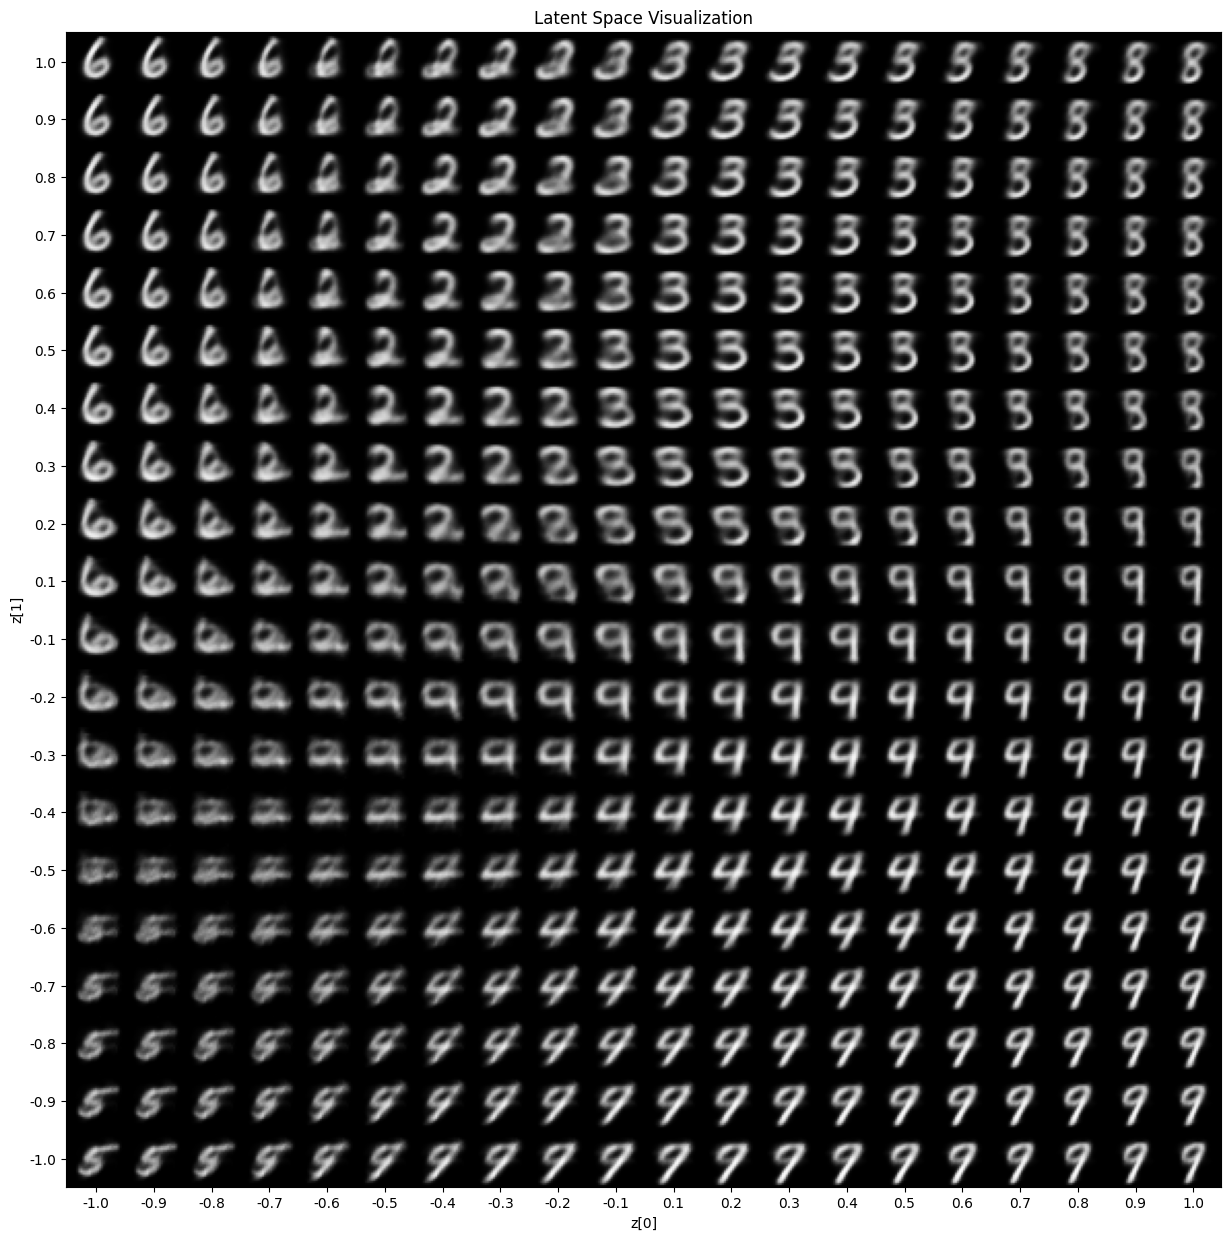

In [19]:
plot_latent_space(model, scale=1.0)

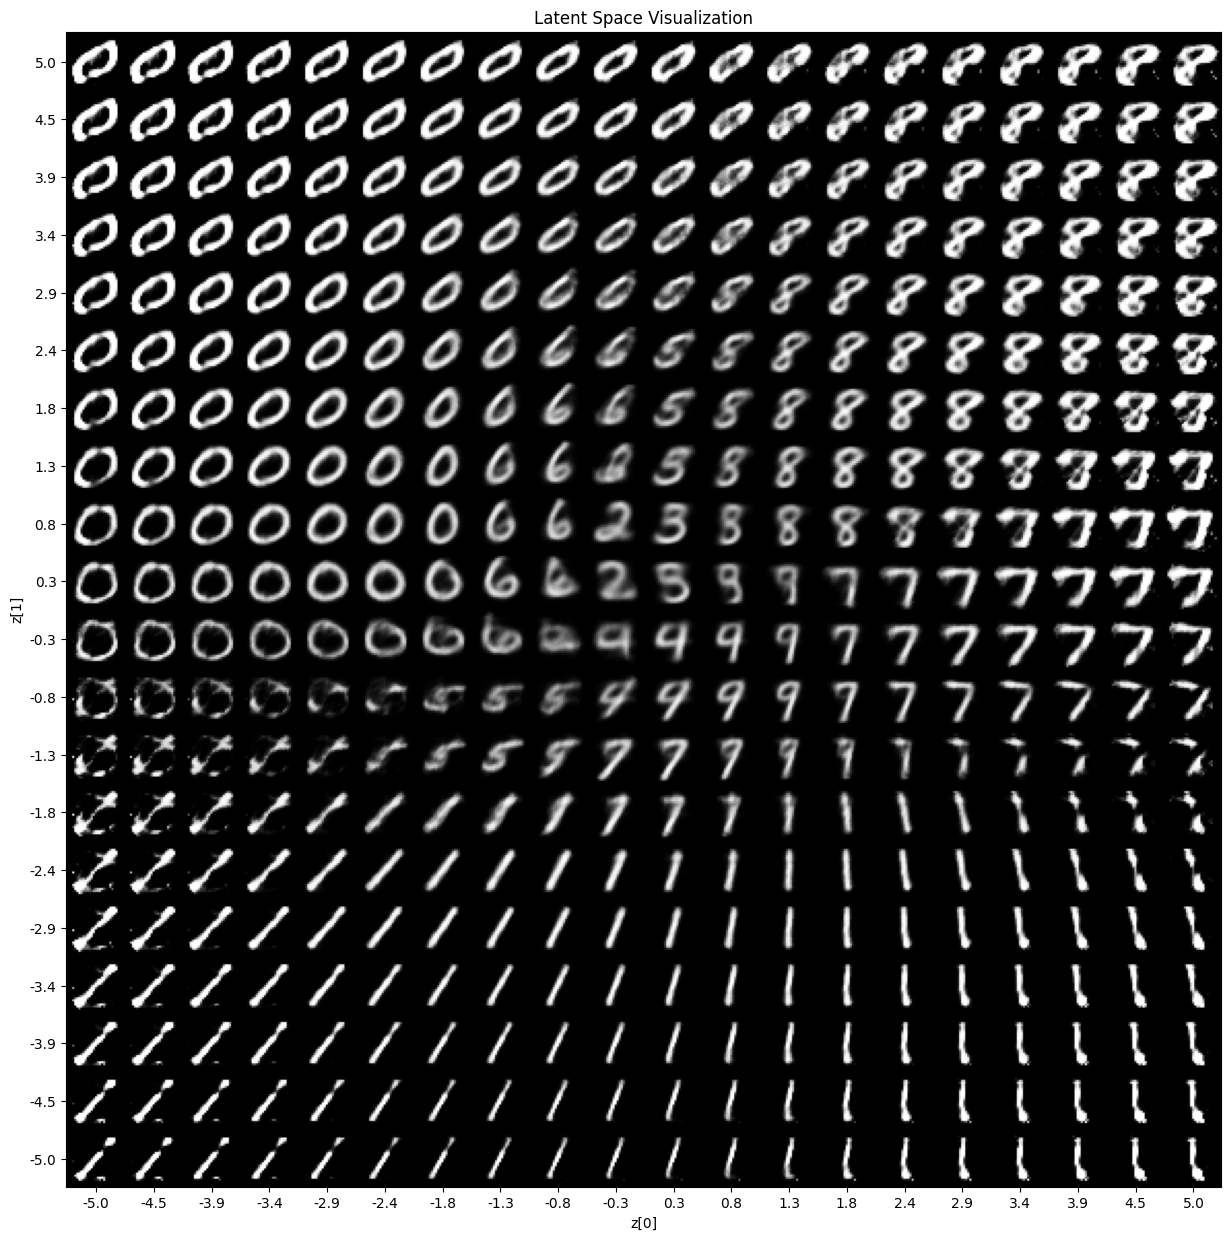

In [20]:
plot_latent_space(model, scale=5.0)

# Linear Interpolation

In [23]:
def linear_interpolation(model, num_steps=10):
    test_loader_iter = iter(test_loader)
    images, labels = next(test_loader_iter)
    labels_np = labels.numpy()
    unique_labels = np.unique(labels_np)
    
    l1, l2 = np.random.choice(unique_labels, size=2, replace=False)
    idx1 = (labels == l1).nonzero()[0].item()
    idx2 = (labels == l2).nonzero()[0].item()
    
    img1 = images[idx1].view(-1, 784).to(device)
    img2 = images[idx2].view(-1, 784).to(device)
    
    with torch.no_grad():
        model.eval()
        mean1, log_var1 = model.encoder(img1)
        z1 = model.reparameterize(mean1, log_var1)
        mean2, log_var2 = model.encoder(img2)
        z2 = model.reparameterize(mean2, log_var2)
    
    interpolation = []
    for t in np.linspace(0, 1, num_steps):
        z = (1 - t) * z1 + t * z2
        x_hat = model.decoder(z).detach().cpu().view(28, 28).numpy()
        interpolation.append(x_hat)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 2))
    for i, ax in enumerate(axes):
        ax.imshow(interpolation[i], cmap="gray")
        ax.axis('off')
        ax.set_title(f"{(i/(num_steps-1)):.2f}")
    plt.suptitle(f"Linear Interpolation between digits {l1} and {l2}")
    plt.show()

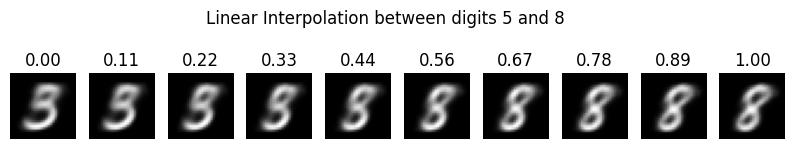

In [25]:
linear_interpolation(model, num_steps=10)